In [245]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,DBSCAN

In [2]:
df=pd.read_csv('../HubSpot/week1_churn.csv')

### A Quick Overview

In [3]:
df.describe()

,stat_week,m,d,user id,stats_trackers_created,stats_sent_notifications_desktop,stats_gmail_insights_viewed,stats_insights_viewed,stats_activities_zapier,stats_stream_viewed
count,6456.000000,6456.000000,6456.000000,6456.000000,6456.000000,6456.000000,6456.000000,6456.000000,6456.0,6456.000000
mean,39.674566,9.717937,15.006196,3228.500000,1.655514,2.394362,3.107497,0.013011,0.0,3.236679
std,1.300972,0.450039,9.084164,1863.831001,2.077874,5.849970,10.531730,0.290545,0.0,2.790333
min,38.000000,9.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,39.000000,9.000000,7.000000,1614.750000,1.000000,1.000000,0.000000,0.000000,0.0,2.000000
50%,40.000000,10.000000,15.000000,3228.500000,1.000000,1.000000,1.000000,0.000000,0.0,3.000000
75%,41.000000,10.000000,24.000000,4842.250000,2.000000,2.000000,3.000000,0.000000,0.0,4.000000
max,42.000000,10.000000,30.000000,6456.000000,66.000000,293.000000,412.000000,16.000000,0.0,50.000000


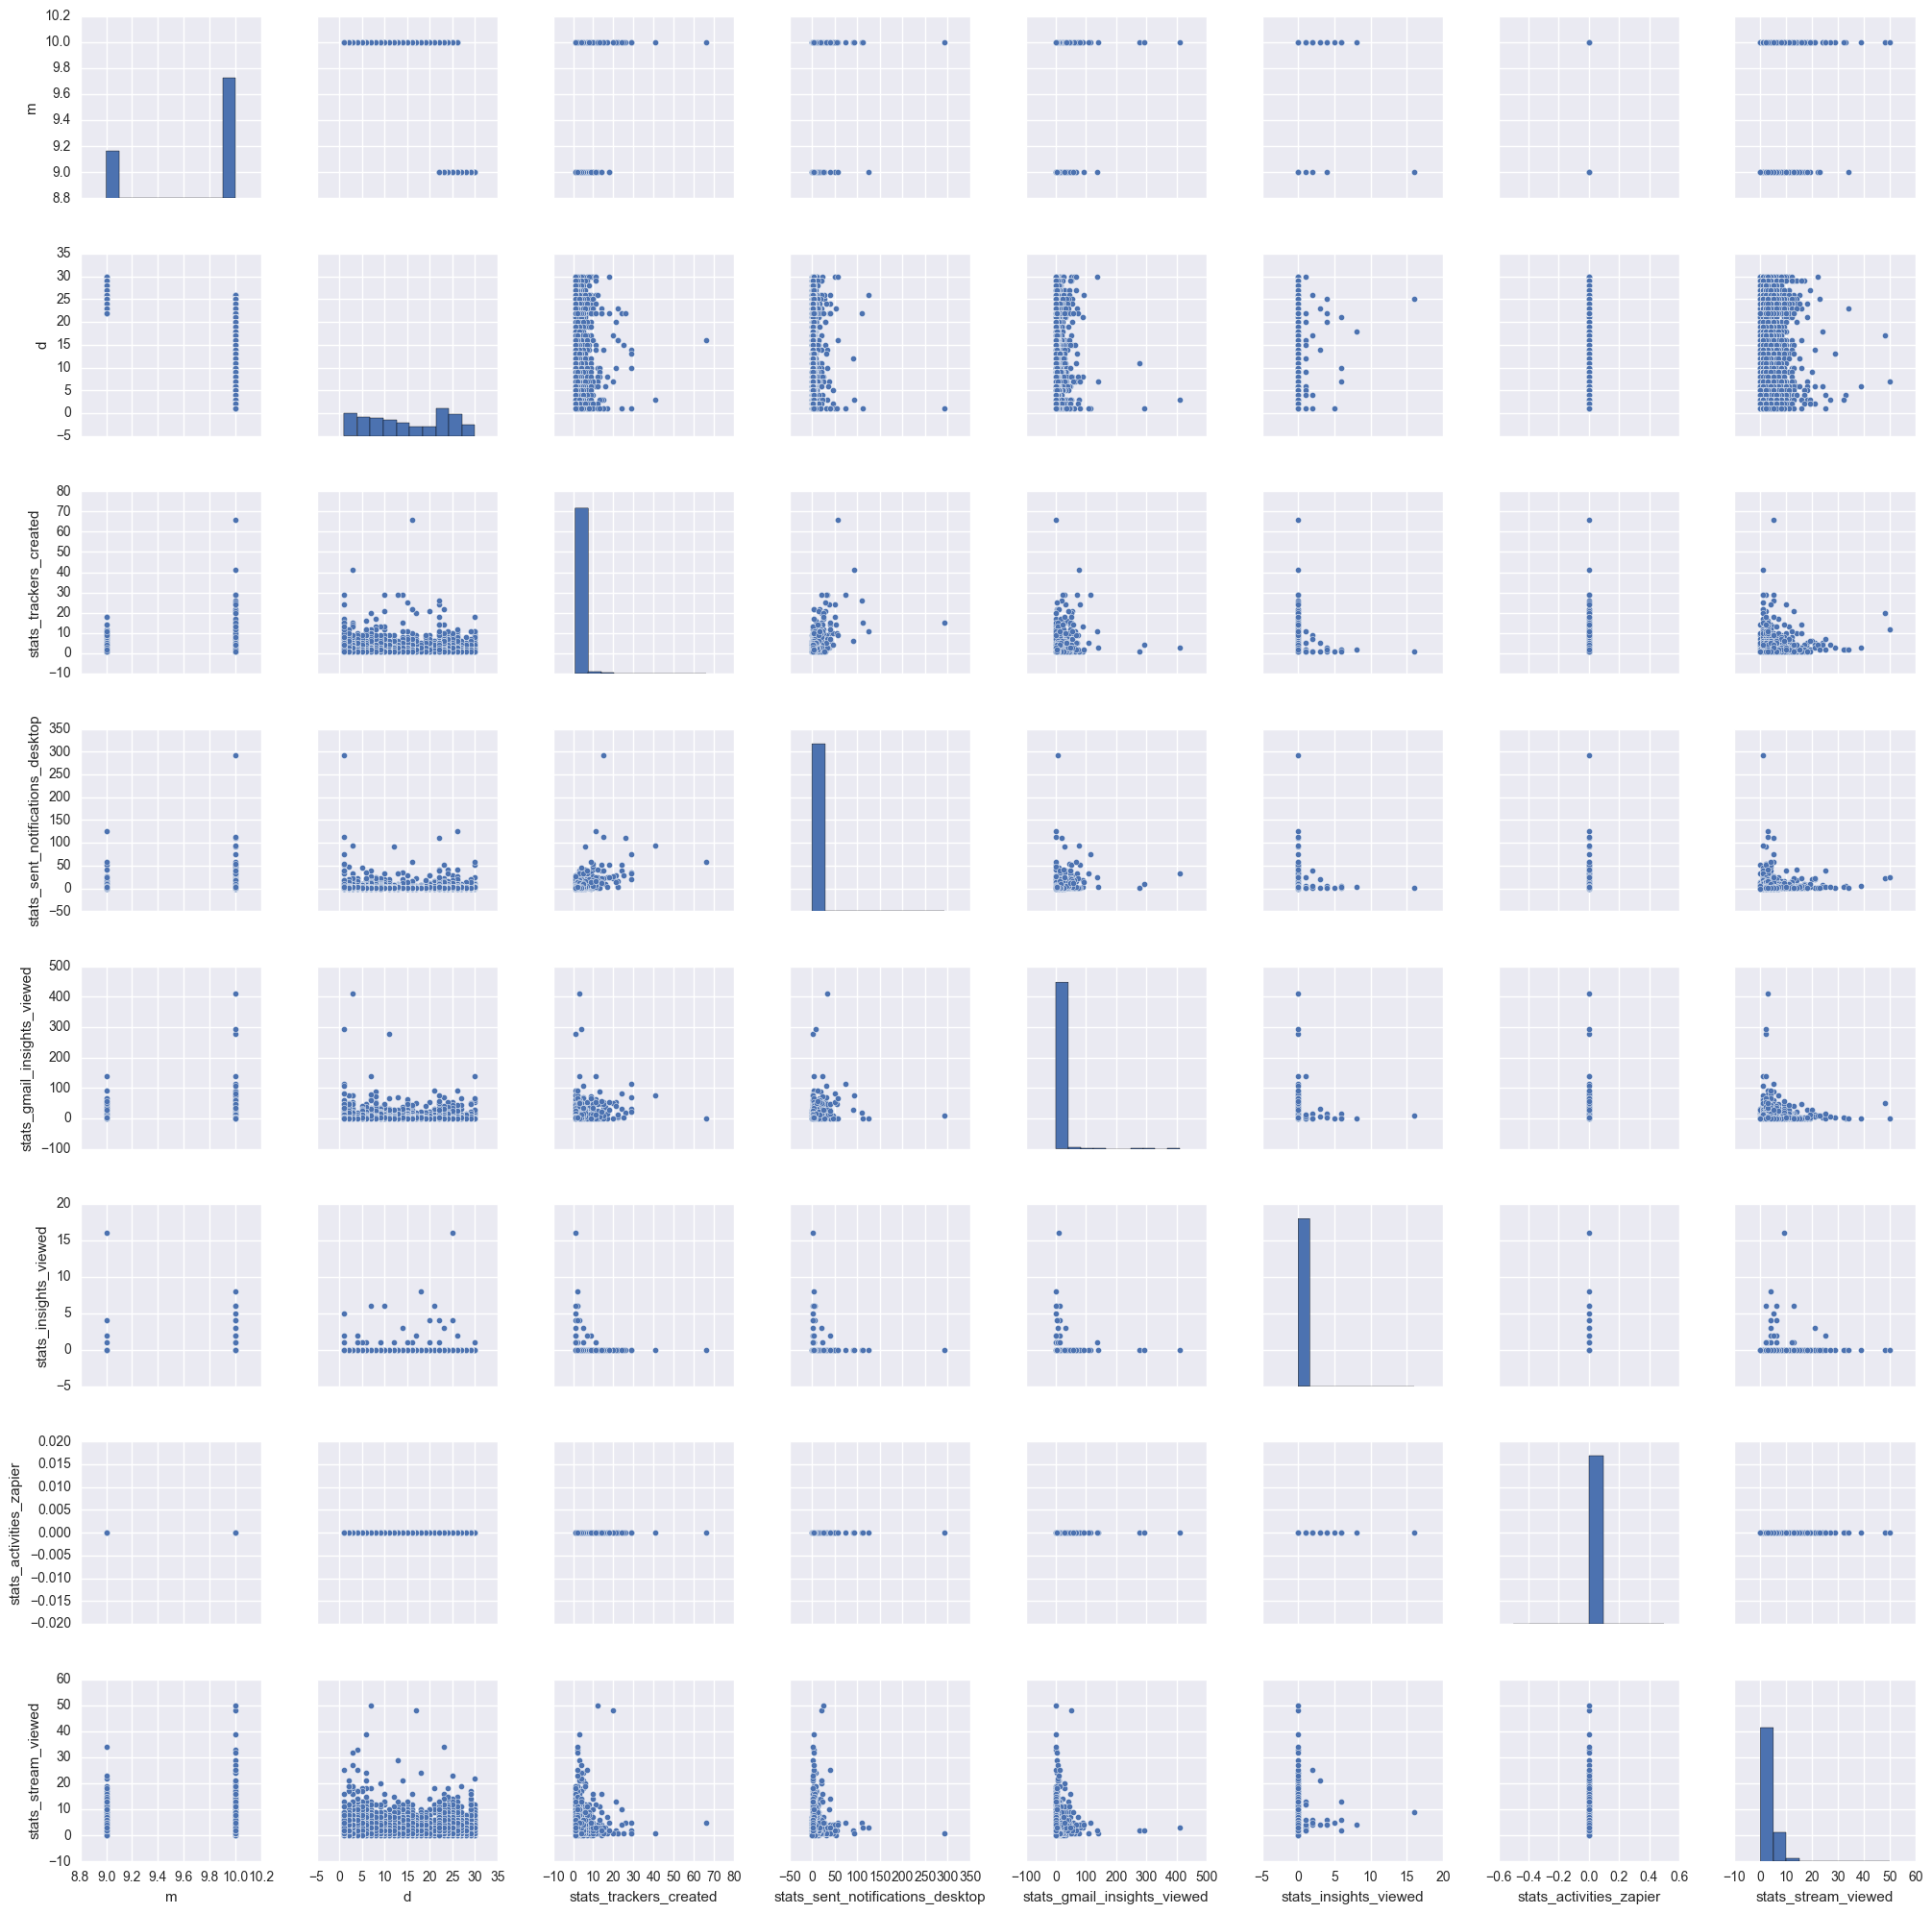

In [8]:
sns.pairplot(df[[u'm', u'd',u'stats_trackers_created',
       u'stats_sent_notifications_desktop', u'stats_gmail_insights_viewed',
       u'stats_insights_viewed', u'stats_activities_zapier',
       u'stats_stream_viewed']])
plt.show()

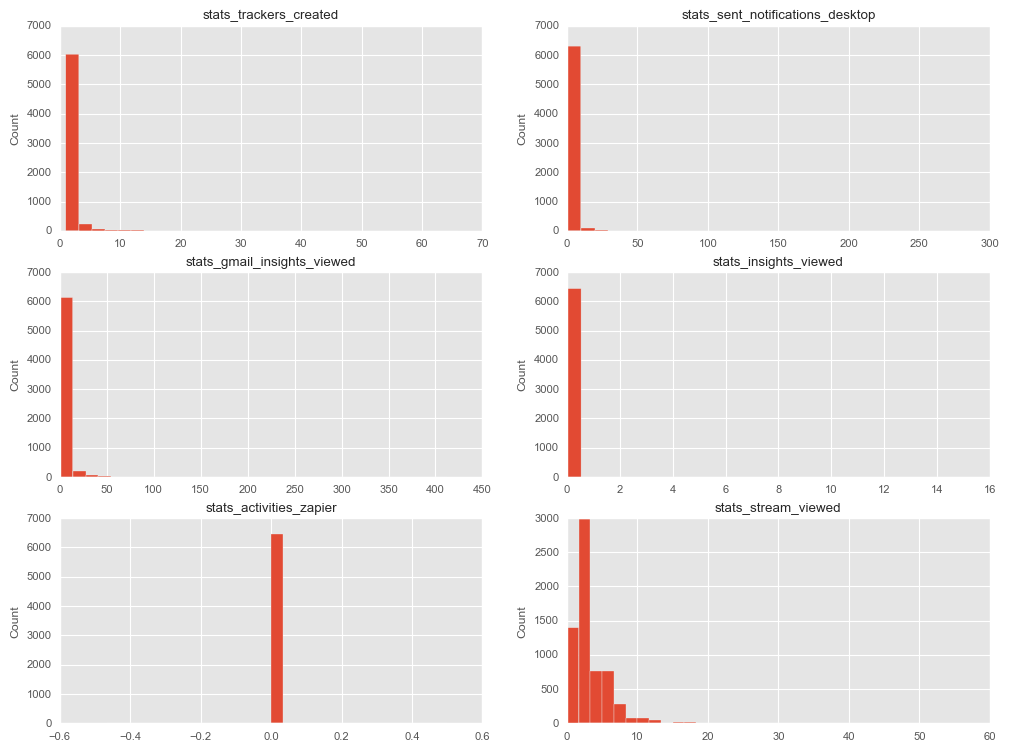

In [257]:
columns=[u'stats_trackers_created',
 u'stats_sent_notifications_desktop',
 u'stats_gmail_insights_viewed',
 u'stats_insights_viewed',
 u'stats_activities_zapier',
 u'stats_stream_viewed']

plt.subplots(2,3,figsize=(12,9))
for col in range(1,len(columns)+1):
    plt.subplot(3,2,col)
    plt.hist(df[columns[col-1]],bins=30)
    plt.title("%s"%(columns[col-1]))
#     plt.xlabel('')
    plt.ylabel('Count')
plt.show()

The data doesn't really have any distribtutions. The only data with a real distribution is stats_stream_viewed. With customers who use the service only once, this is to be expected because they will not use the software to the fullest of its potential. 

### Periodic Trends

In [10]:
df['day+month']=df['d'].astype(str)+','+df['m'].astype(str)

In [199]:
print(plt.style.available)

[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


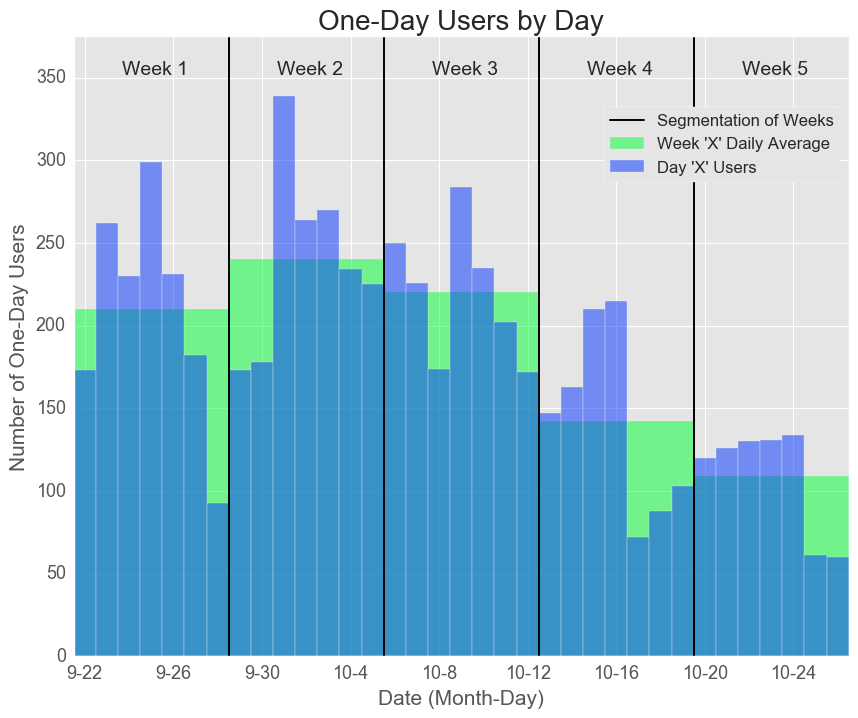

In [227]:
# Temporary DataFrames
temp=df.groupby(['d','m'])['day+month'].count().to_frame().reset_index()
temp=temp.sort_values(by=['m','d']).reset_index()
del temp['index']
temp2=df.groupby(['stat_week'])['user id'].count().to_frame().reset_index()

# Plot Initializations
plt.style.use('ggplot')
plt.style.use('seaborn-paper')
plt.subplots(figsize=(10,8))

# Barcharts
plt.bar(range(0,temp.index[-1],7),temp2['user id']/7,color=(0,1,.2,.5),width=7,label="Week 'X' Daily Average")
plt.bar(temp.index,temp['day+month'],width=1,color=(0,.2,1,.5),label="Day 'X' Users")

# Vertical Lines
plt.vlines(range(7,temp.index[-1],7),0,375,label='Segmentation of Weeks')
i=1
for item in range(0,temp.index[-1],7):
    plt.text(item+2.2,352,'Week %s' %(i),size=14)
    i+=1

# Plot Axes and Lables
plt.title('One-Day Users by Day',size=20)
plt.xlabel("Date (Month-Day)",size=15)
plt.ylabel('Number of One-Day Users',size=15)
plt.ylim(0,375)
plt.xticks([x+.5 for x in range(0,temp.index[-1],4)],[str(y)+'-'+str(x) for x,y in \
            zip(temp.iloc[range(0,temp.index[-1],4)]['d'].values,\
                temp.iloc[range(0,temp.index[-1],4)]['m'].values)],rotation=0,size=13)
plt.yticks(size=13)
plt.legend(bbox_to_anchor=(1.,0.9),frameon=True,fontsize='large')

plt.show()

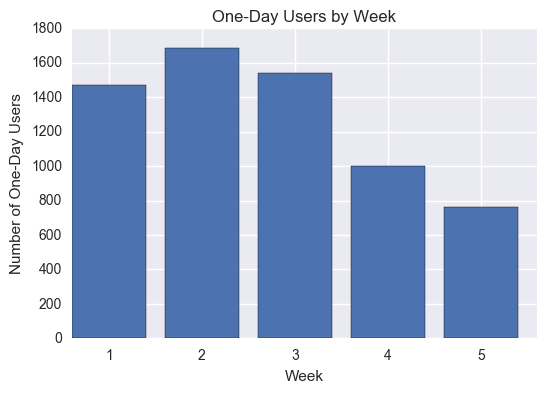

In [120]:
temp=df.groupby(['stat_week'])['user id'].count().to_frame().reset_index()
plt.bar(temp['stat_week'],temp['user id'])
plt.xticks(np.linspace(38.4,42.4,5),range(1,7))
plt.xlabel("Week")
plt.ylabel("Number of One-Day Users")
plt.title('One-Day Users by Week')
plt.show()

There doesn't seem to be any temporal trend; this data is not periodic.

### Basic Data Correlation

In [99]:
def color(x):
    color="Black"
    if (np.abs(x)>0.3) and (np.abs(x)<1):
        color="white"
    return 'background-color: %s' %color

df.corr().style.applymap(color)

There are a few features with high correlation, but most of those features are nonsense. For instance, correlation between month and anything else is useless, so we ignore that feature. In fact, the only pair of features that have significant correlation are ('stats_trackers_created','stats_sent_notifications_desktop') and ('stats_trackers_created','stats_gmail_insights_viewed'). The first pairing should be expected, as trackers are created, one would expect stat notifications to increase proportionately. One could possibly find more correlated figures if the data was broken apart by industry. The second pairing suggests a minor relationship between sending emails and viewing gmail profiles. Gmail profile views aren't that important, LinkedIn should be the real focus.

### Advanced Data Correlation

In [259]:
# We will use these columns for our PCA, and possibly our DBSCAN

columns=[u'stats_trackers_created',
     u'stats_sent_notifications_desktop',
     u'stats_gmail_insights_viewed',
     u'stats_insights_viewed',
     u'stats_activities_zapier',
     u'stats_stream_viewed']

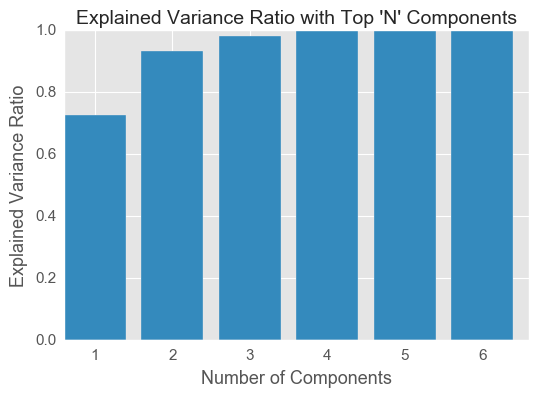

[ 0.72783246  0.93288428  0.98193442  0.9994657   1.          1.        ]


In [273]:
pca=PCA()
pca.fit(df[columns])
evr=pca.explained_variance_ratio_
plt.bar(range(0,len(np.cumsum(evr))),np.cumsum(evr))
plt.ylim(0,1.)
plt.xticks(np.linspace(0.4,5.4,6),range(1,7),size=11)
plt.yticks(size=11)
plt.xlabel("Number of Components",size=13)
plt.ylabel("Explained Variance Ratio",size=13)
plt.title("Explained Variance Ratio with Top 'N' Components",size=14)
plt.show()
print np.cumsum(evr)

We can map the 6-Dimensional space onto a 2-Dimensional space without losing more than 7% of information. This is acceptable

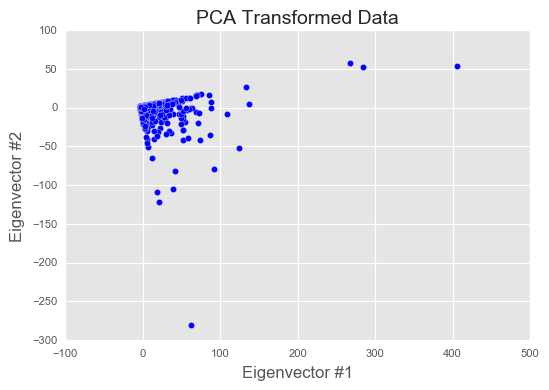

In [281]:
pca=PCA(n_components=2)
transformed_data=pca.fit_transform(df[columns])

plt.scatter(transformed_data[:,0],transformed_data[:,1])
plt.title("PCA Transformed Data",size=14)
plt.xlabel('Eigenvector #1',size=12)
plt.ylabel("Eigenvector #2",size=12)
plt.show()

From the Eigenvector transform, it becomes apparent that there are not unique clusters within the data. To find out more about the data, it would be necessary for general company information.

### Thoughts on the Data

There is not a lot of meat on this bone; the data certainly holds information about usage rates among a certain user base, but there is nothing to break the data apart by, not even temporal trends present themselves. I've checked correlations, eigenvectors, and date-time trends, but all of these tools indicate that the data is too mixed or too uniform to find any major insights. To break apart this data, I would need information about the company (such as industry, years since inception, company size, funding level, and number of employees). I would also request information about the type of program these users had signed up for, as to better understand their motivations for using the software. Without understanding a client's motivation, one can not possibly hope to predict a client's actions with accuracy. I would lastly request data to compare these one-day users to. I would want to know whether their actions are at all unique, or whether they had fairly similar first days to continuing users. 

The point of requesting company data, client motivation data, and support data is to a) create more representative subsets of the data, and b) use comparitive analysis to determine what actions need to be taken in order to onboard these potentially subscribing clients.

If I were to get really specific about the data, I would also request information of every action each client does within the software. I want to find the hangup points of the software, along with the most important sections of the software.